In [ ]:
!pip install -q pandas openpyxl tensorflow matplotlib scikit-learn

In [ ]:
import pandas as pd

# Load labeled Excel file
df = pd.read_excel("TrainVersion_labeled.xlsx")

# Drop rows with missing text or labels
df = df.dropna(subset=['text', 'Sentiment Label'])
df.head()

,text,Sentiment Label,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,4:31 LIM JU KYUNG’S SHIRT !?,0,NaN,NaN,NaN
1,Malaysia is so under rated. Its a beautiful co...,1,NaN,NaN,NaN
2,I believe where you are now is the top 3\nIsla...,1,NaN,NaN,NaN
3,Missed you guys!,1,NaN,NaN,NaN
4,THE FOOD LOOKS SO GOOD HOPE YOU ENJOYEDDD,1,NaN,NaN,NaN


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['cleaned_text'] = df['text'].astype(str).apply(clean_text)



In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Convert sentiment label to categorical [0, 1, 2]
label_map = {-1: 0, 0: 1, 1: 2}
mapped_labels = df['Sentiment Label'].map(label_map).tolist()
y = to_categorical(mapped_labels, num_classes=3)

# Tokenize text
texts = df['cleaned_text'].astype(str).tolist()
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100, padding='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from collections import Counter
print(Counter(df['Sentiment Label']))

Counter({1: 1220, -1: 792, 0: 717})


In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(mapped_labels),
    y=mapped_labels
)
class_weights = {i: class_weights_array[i] for i in range(3)}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.1485690235690236), 1: np.float64(1.2687122268712228), 2: np.float64(0.7456284153005465)}


In [ ]:
!wget --no-check-certificate "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip -o glove.6B.zip

--2025-06-30 10:28:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-30 10:28:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-30 10:28:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
embedding_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 400000 word vectors.


In [ ]:
embedding_dim = 100  # Must match glove.6B.100d.txt
word_index = tokenizer.word_index
num_words = min(5000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(5000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 5000:
        continue
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=100,
              trainable=True),  # ✅ fine-tune embeddings
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, 100))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       404,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811,699 (3.10 MB)

 Trainable params: 811,699 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 615ms/step - accuracy: 0.6071 - loss: 0.8384 - val_accuracy: 0.8260 - val_loss: 0.4545
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 686ms/step - accuracy: 0.8519 - loss: 0.3813 - val_accuracy: 0.8242 - val_loss: 0.4828
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 76s 593ms/step - accuracy: 0.8908 - loss: 0.3092 - val_accuracy: 0.8407 - val_loss: 0.4073
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 579ms/step - accuracy: 0.9110 - loss: 0.2541 - val_accuracy: 0.8462 - val_loss: 0.3979
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 44s 645ms/step - accuracy: 0.9206 - loss: 0.2125 - val_accuracy: 0.8407 - val_loss: 0.4738
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 80s 617ms/step - accuracy: 0.9461 - loss: 0.1477 - val_accuracy: 0.8278 - val_loss: 0.5141
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 605ms/step - accuracy: 0.9619 - loss: 0.1131 - val_accuracy: 0.8278 - val_loss: 0.6362


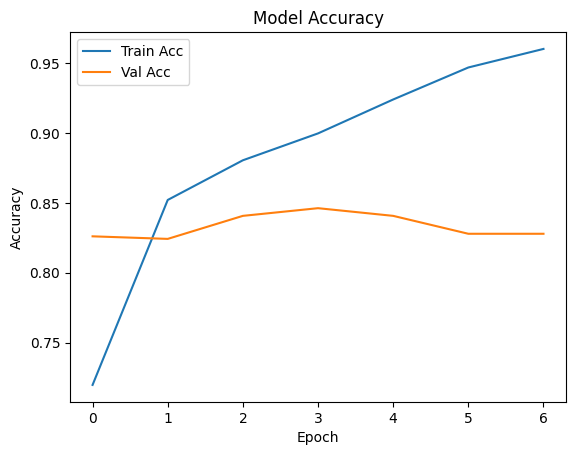

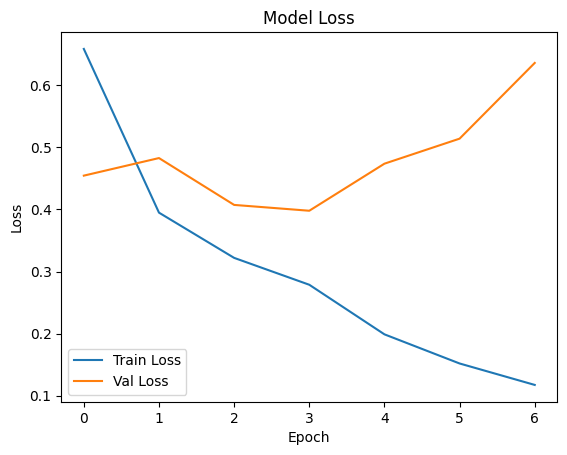

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step
Classification Report:

              precision    recall  f1-score   support

    Negative       0.92      0.85      0.88       176
     Neutral       0.70      0.84      0.76       137
    Positive       0.90      0.85      0.87       233

    accuracy                           0.85       546
   macro avg       0.84      0.85      0.84       546
weighted avg       0.86      0.85      0.85       546



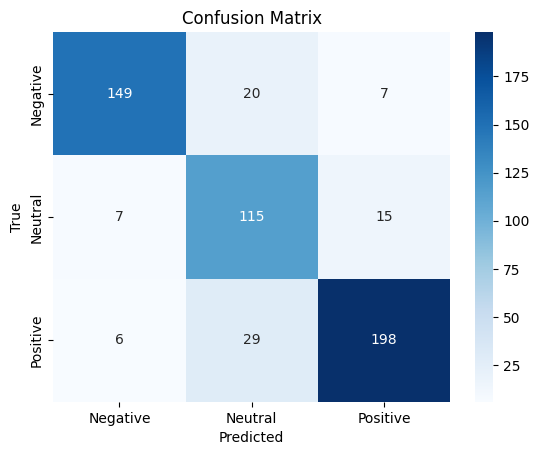

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
target_names = ['Negative', 'Neutral', 'Positive']
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Optional: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

# Label decoding: 0 → Negative, 1 → Neutral, 2 → Positive
label_reverse_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

def predict_sentiment(text):
    # Clean it same way as training
    cleaned = clean_text(text)

    # Tokenize & pad
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=100, padding='post')

    # Predict
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get readable label
    return label_reverse_map[predicted_class], prediction[0]




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: Malaysia is bad in everything, I dont like it
Predicted Sentiment: Negative | Probabilities: [0.9452336  0.03994196 0.01482441]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Text: I really enjoyed my trip to Langkawi, it's a beautiful island!
Predicted Sentiment: Positive | Probabilities: [5.6723558e-04 4.4669579e-03 9.9496573e-01]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Text: It is normal
Predicted Sentiment: Neutral | Probabilities: [0.11133831 0.82673925 0.06192254]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Text: I had a bad experience during my travel in Malaysia. Very disappointed.
Predicted Sentiment: Negative | Probabilities: [9.9781358e-01 1.4837639e-03 7.0260710e-04]



In [ ]:
model.save("lstm_glove_model.h5")

import pickle

# Save tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
